# Baseline text models – tender title classification

This notebook recreates the quick CLI benchmark **and** adds:

* Precision–Recall curves for a richer view of performance  
* A dense-embedding baseline (Sentence-BERT)

> Requires the same virtual-env you already use (`sentence-transformers`, scikit-learn, pandas, seaborn, etc.) and access to the database credentials/secret.


In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    f1_score,
    precision_recall_curve,
    average_precision_score,
)

# Project helper
from prepare_data import load_clean_dataframe

In [4]:
df = load_clean_dataframe(labelled_only=True)
print(df.head())
print(df["bid"].value_counts())

X = df[["title", "ca", "procedure"]]
y = df["bid"].values

RANDOM_STATE = 42
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

                                               title  \
0                   7651 CIE Board Advisory Services   
1  Provision of Vehicles Adapted for Person with ...   
2  2313 - QUALIFICATION SYSTEM for Mechanical and...   
3  DPS Q FOR CONTRAST INJECTORS CT ANGIO MRI AND ...   
4  HSE 21712 National DPS Qualification for Opera...   

                                     ca                  procedure  bid  
0   Coras Iompair Eireann (CIE Utility)       Qualification System    0  
1  Brothers of Charity Services Ireland  Dynamic Purchasing System    0  
2                           An Post_391  Dynamic Purchasing System    0  
3        Health Service Executive (HSE)  Dynamic Purchasing System    0  
4        Health Service Executive (HSE)  Dynamic Purchasing System    0  
bid
0    1955
1     139
Name: count, dtype: int64


/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  # Drop rows where *title* is missing entirely – they are useless for our
/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [5]:
def make_pipeline(vectoriser, classifier):
    """Combine text + categorical features in a single scikit-learn Pipeline."""
    categorical = ["ca", "procedure"]

    ct = ColumnTransformer(
        [
            ("text", vectoriser, "title"),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ]
    )

    return Pipeline([("features", ct), ("clf", classifier)])

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class SentenceEmbeddings(BaseEstimator, TransformerMixin):
    """Wrap a Sentence-Transformer model so it plugs into scikit-learn."""
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", batch_size=32):
        self.model_name = model_name
        self.batch_size = batch_size

    def fit(self, X, y=None):
        from sentence_transformers import SentenceTransformer  # local import avoids heavy load at notebook start
        self.model_ = SentenceTransformer(self.model_name)
        return self

    def transform(self, X):
        texts = (
            X if isinstance(X, (pd.Series, list, np.ndarray))
            else X["title"]
        )
        return self.model_.encode(
            texts.tolist(),
            batch_size=self.batch_size,
            show_progress_bar=False,
        )

In [7]:
models = {
    "TF-IDF + LogReg": make_pipeline(
        TfidfVectorizer(ngram_range=(1, 2), min_df=3),
        LogisticRegression(
            max_iter=10_000,
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE,
        ),
    ),
    "TF-IDF + Linear SVM": make_pipeline(
        TfidfVectorizer(ngram_range=(1, 2), min_df=3),
        LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
    ),
    "Hashing + LogReg": make_pipeline(
        HashingVectorizer(analyzer="word", n_features=2 ** 18),
        LogisticRegression(
            max_iter=10_000,
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE,
        ),
    ),
}

# Dense embedding baseline
models["SBERT + LogReg"] = Pipeline(
    [
        ("embed", SentenceEmbeddings()),
        ("scale", StandardScaler()),  # optional but helps LR converge faster
        ("clf", LogisticRegression(
            max_iter=10_000,
            class_weight="balanced",
            random_state=RANDOM_STATE,
        )),
    ]
)

In [8]:
results = {}
scores_dict = {}  # out-of-fold scores for PR curve

for name, model in models.items():
    print(f"Evaluating {name} …")

    # Decide which method returns a usable score for PR curve
    has_proba = hasattr(model, "predict_proba") or "LogReg" in name
    pr_method = "predict_proba" if has_proba else "decision_function"

    # Out-of-fold predictions
    y_pred = cross_val_predict(model, X, y, cv=CV, method="predict")
    f1 = f1_score(y, y_pred)
    results[name] = f1

    # Out-of-fold decision scores
    if pr_method == "predict_proba":
        y_score = cross_val_predict(model, X, y, cv=CV, method="predict_proba")[:, 1]
    else:
        y_score = cross_val_predict(model, X, y, cv=CV, method="decision_function")

    scores_dict[name] = y_score

(pd.Series(results)
   .sort_values(ascending=False)
   .to_frame("F1")
   .style.format({"F1": "{:.3f}"}))

Evaluating TF-IDF + LogReg …
Evaluating TF-IDF + Linear SVM …
Evaluating Hashing + LogReg …
Evaluating SBERT + LogReg …


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,F1
SBERT + LogReg,0.540
TF-IDF + Linear SVM,0.530
TF-IDF + LogReg,0.516
Hashing + LogReg,0.450


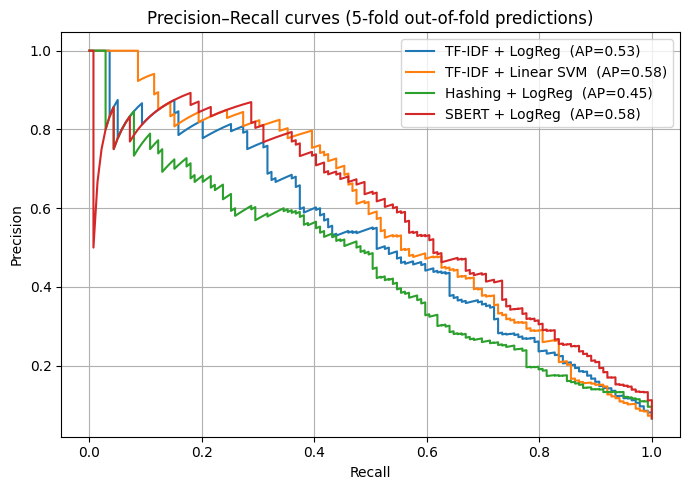

In [9]:
plt.figure(figsize=(7, 5))

for name, y_score in scores_dict.items():
    precision, recall, _ = precision_recall_curve(y, y_score)
    ap = average_precision_score(y, y_score)
    plt.plot(recall, precision, label=f"{name}  (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (5-fold out-of-fold predictions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Observations

* Which model achieves the highest F1 / Average Precision?
* Does SBERT offer a measurable lift compared with TF-IDF?
* Consider cost/latency vs. accuracy when deciding what to put in production.

In [10]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import Bunch

THRESH = 0.30          # <- play with this
cv_preds = Bunch()

for name, model in models.items():
    # choose proper scoring method
    has_proba = hasattr(model, "predict_proba") or "LogReg" in name
    method = "predict_proba" if has_proba else "decision_function"

    # out-of-fold raw scores
    scores = (
        cross_val_predict(model, X, y, cv=CV, method=method)[:, 1]
        if method == "predict_proba"
        else cross_val_predict(model, X, y, cv=CV, method=method)
    )

    # binarise at chosen threshold
    y_pred = (scores >= THRESH).astype(int)
    cv_preds[name] = y_pred

    print(f"\n=== {name} (threshold {THRESH}) ===")
    print(classification_report(y, y_pred, target_names=["No-bid", "Bid"]))


=== TF-IDF + LogReg (threshold 0.3) ===
              precision    recall  f1-score   support

      No-bid       0.98      0.82      0.89      1955
         Bid       0.24      0.80      0.37       139

    accuracy                           0.82      2094
   macro avg       0.61      0.81      0.63      2094
weighted avg       0.93      0.82      0.86      2094


=== TF-IDF + Linear SVM (threshold 0.3) ===
              precision    recall  f1-score   support

      No-bid       0.96      0.98      0.97      1955
         Bid       0.68      0.46      0.55       139

    accuracy                           0.95      2094
   macro avg       0.82      0.72      0.76      2094
weighted avg       0.94      0.95      0.95      2094


=== Hashing + LogReg (threshold 0.3) ===
              precision    recall  f1-score   support

      No-bid       0.98      0.78      0.87      1955
         Bid       0.20      0.78      0.32       139

    accuracy                           0.78      2094


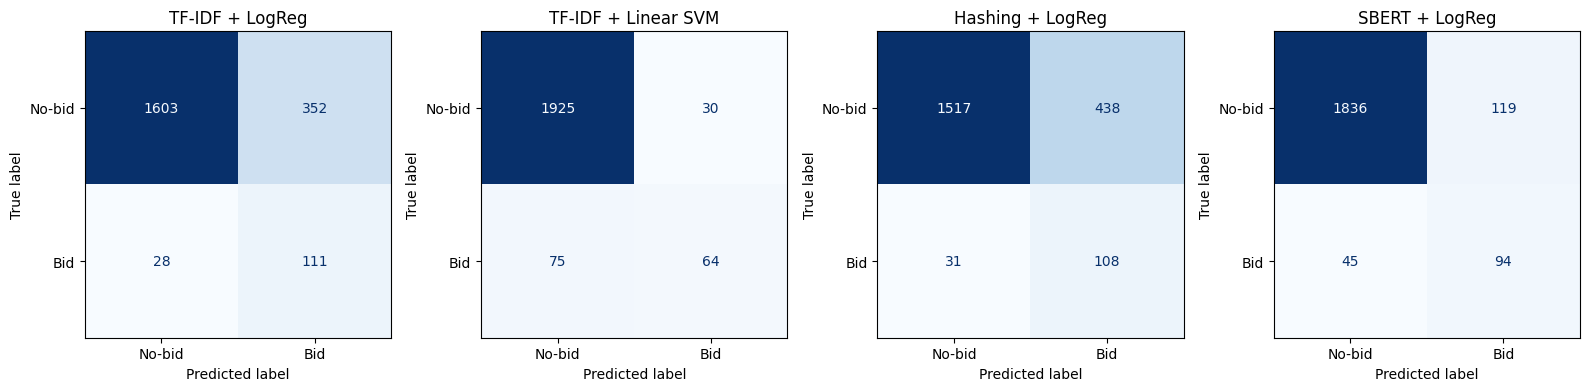

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(cv_preds), figsize=(4 * len(cv_preds), 4))

for ax, (name, y_pred) in zip(axes, cv_preds.items()):
    ConfusionMatrixDisplay.from_predictions(
        y, y_pred, display_labels=["No-bid", "Bid"],
        cmap="Blues", ax=ax, colorbar=False
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

      No-bid       0.97      0.91      0.94       391
         Bid       0.33      0.64      0.43        28

    accuracy                           0.89       419
   macro avg       0.65      0.77      0.69       419
weighted avg       0.93      0.89      0.90       419



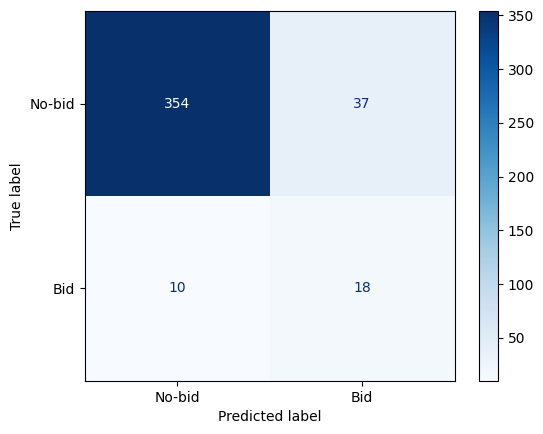

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

model = models["SBERT + LogReg"]          # pick any model
model.fit(X_train, y_train)

# probability → hard label at chosen threshold
scores = model.predict_proba(X_test)[:, 1]
threshold = 0.30
y_pred = (scores >= threshold).astype(int)

print(classification_report(y_test, y_pred, target_names=["No-bid", "Bid"]))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)

              precision    recall  f1-score   support

      No-bid       0.96      0.99      0.97       391
         Bid       0.83      0.36      0.50        28

    accuracy                           0.95       419
   macro avg       0.89      0.68      0.74       419
weighted avg       0.95      0.95      0.94       419



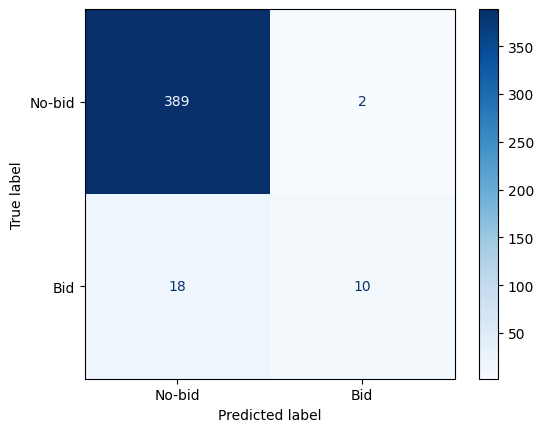

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

model = models["TF-IDF + Linear SVM"]   # or any other
model.fit(X_train, y_train)

# get a continuous score for each sample
if hasattr(model, "predict_proba"):
    scores = model.predict_proba(X_test)[:, 1]
else:
    scores = model.decision_function(X_test)      # LinearSVC margin

# convert score → class label at chosen threshold
threshold = 0.30
y_pred = (scores >= threshold).astype(int)

print(classification_report(y_test, y_pred, target_names=["No-bid", "Bid"]))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)

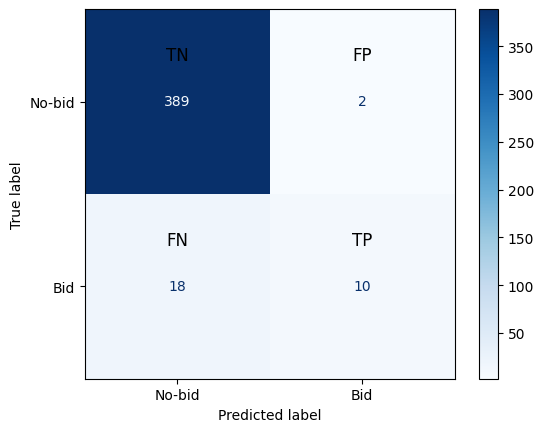

In [19]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)
ax = disp.ax_            # the underlying axes

# Coordinates: (col, row)
labels = { (0,0): "TN", (1,0): "FP",
           (0,1): "FN", (1,1): "TP" }

for (col, row), txt in labels.items():
    ax.text(col, row-0.25, txt,   # a bit above the count
            ha="center", va="center", fontsize=12, color="black")

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.show()

Chosen threshold = 0.00
              precision    recall  f1-score   support

      No-bid       0.96      0.98      0.97       391
         Bid       0.67      0.50      0.57        28

    accuracy                           0.95       419
   macro avg       0.82      0.74      0.77       419
weighted avg       0.94      0.95      0.95       419



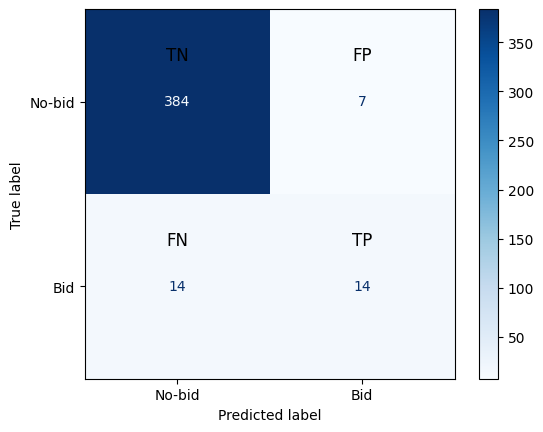

In [28]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
)

# --- assume `scores` (float 0-1) and `y_test` are already computed ---

# def threshold_sweep(scores, y_true, recall_target=0.80, step=0.01):
#     """Return the smallest threshold whose recall ≥ target."""
#     best_thr = 0.0
#     for thr in np.arange(0.0, 1.0, step):
#         y_pred = (scores >= thr).astype(int)
#         r = recall_score(y_true, y_pred)
#         if r >= recall_target:
#             best_thr = thr
#             break
#     return best_thr

def threshold_sweep(scores, y_true, recall_target=0.80, step=0.01):
    for thr in np.arange(1.0, -step, -step):       # 1.00, 0.99, …
        y_pred = (scores >= thr).astype(int)
        if recall_score(y_true, y_pred) >= recall_target:
            return thr            # first (highest) that meets recall
    return 0.0                    # fallback

# 1️⃣ find threshold
best_thr = threshold_sweep(scores, y_test, recall_target=0.60, step=0.01)
print(f"Chosen threshold = {best_thr:.2f}")

# 2️⃣ apply threshold
y_pred = (scores >= best_thr).astype(int)

# 3️⃣ report
print(classification_report(y_test, y_pred, target_names=["No-bid", "Bid"]))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["No-bid", "Bid"], cmap="Blues"
)
ax = disp.ax_
# add TN / FP / FN / TP labels
for (col,row),txt in { (0,0):"TN",(1,0):"FP",(0,1):"FN",(1,1):"TP" }.items():
    ax.text(col, row-0.25, txt, ha="center", va="center", fontsize=12)
plt.show()

In [29]:
import numpy as np
from sklearn.metrics import precision_recall_curve, recall_score

def threshold_for_recall(scores, y_true, recall_target=0.80):
    """
    Return the **highest** threshold that still achieves
    recall ≥ recall_target.

    Works for both probability outputs (0–1) and raw
    margins (can be −∞…+∞, e.g. LinearSVC.decision_function).
    """
    prec, rec, thr = precision_recall_curve(y_true, scores)
    # precision_recall_curve returns one fewer thresholds than recalls
    # Pair each recall value with the threshold that produced it.
    candidates = zip(rec[:-1], thr)
    # keep only those that meet the target, then take the largest threshold
    valid = [t for r, t in candidates if r >= recall_target]
    return max(valid) if valid else thr.min()

Chosen threshold = -0.828
              precision    recall  f1-score   support

           0      0.987     0.754     0.855       391
           1      0.200     0.857     0.324        28

    accuracy                          0.761       419
   macro avg      0.593     0.806     0.590       419
weighted avg      0.934     0.761     0.820       419



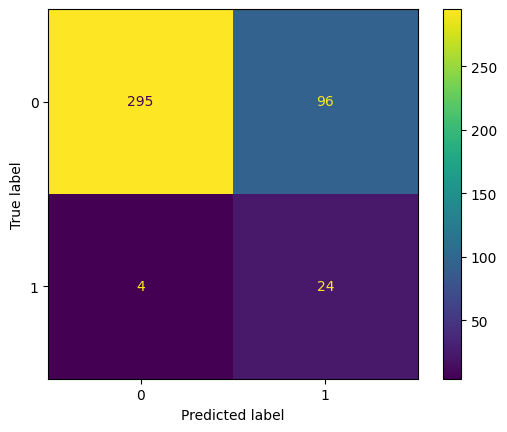

In [34]:
# after you have fitted the model
if hasattr(model, "predict_proba"):
    scores = model.predict_proba(X_test)[:, 1]
else:
    scores = model.decision_function(X_test)        # raw margins

thr = threshold_for_recall(scores, y_test, recall_target=0.85)
print(f"Chosen threshold = {thr:.3f}")

y_pred = (scores >= thr).astype(int)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)